### https://wikidocs.net/24586

In [ ]:
import keras
keras.__version__

# 뉴스 기사 분류: 다중 분류 문제

이 노트북은 [케라스 창시자에게 배우는 딥러닝](https://tensorflow.blog/케라스-창시자에게-배우는-딥러닝/) 책의 3장 5절의 코드 예제입니다. 책에는 더 많은 내용과 그림이 있습니다. 이 노트북에는 소스 코드에 관련된 설명만 포함합니다. 이 노트북의 설명은 케라스 버전 2.2.2에 맞추어져 있습니다. 케라스 최신 버전이 릴리스되면 노트북을 다시 테스트하기 때문에 설명과 코드의 결과가 조금 다를 수 있습니다.

----

이전 섹션에서 완전 연결된 신경망을 사용해 벡터 입력을 어떻게 두 개의 클래스로 분류하는지 보았습니다. 두 개 이상의 클래스가 있을 때는 어떻게 해야 할까요?

이 절에서 로이터 뉴스를 46개의 상호 배타적인 토픽으로 분류하는 신경망을 만들어 보겠습니다. 클래스가 많기 때문에 이 문제는 다중 분류의 예입니다. 각 데이터 포인트가 정확히 하나의 범주로 분류되기 때문에 좀 더 정확히 말하면 단일 레이블 다중 분류 문제입니다. 각 데이터 포인트가 여러 개의 범주(가령, 토픽)에 속할 수 있다면 이런 문제는 다중 레이블 다중 분류의 문제가 됩니다.

## 로이터 데이터셋

1986년에 로이터에서 공개한 짧은 뉴스 기사와 토픽의 집합인 로이터 데이터셋을 사용하겠습니다. 이 데이터셋은 텍스트 분류를 위해 널리 사용되는 간단한 데이터셋입니다. 46개의 토픽이 있으며 어떤 토픽은 다른 것에 비해 데이터가 많습니다. 각 토픽은 훈련 세트에 최소한 10개의 샘플을 가지고 있습니다.

IMDB와 MNIST와 마찬가지로 로이터 데이터셋은 케라스에 포함되어 있습니다. 한 번 살펴보죠:

In [ ]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

In [ ]:
#(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

IMDB 데이터셋에서처럼 num_words=10000 매개변수는 데이터에서 가장 자주 등장하는 단어 10,000개로 제한합니다.

여기에는 8,982개의 훈련 샘플과 2,246개의 테스트 샘플이 있습니다:

위에서 num_words는 이 데이터에서 등장 빈도 순위로 몇 번째에 해당하는 단어까지만 사용할 것인지 조절합니다. 예를 들어서 100이란 값을 넣으면, 등장 빈도 순위가 1~100에 해당하는 단어만 사용하게 됩니다. 모든 단어를 사용하고자 한다면 None으로 설정합니다. 정확하게 무슨 의미인지 이해가 안간다면, 아래에서 훈련 데이터를 출력할 때 출력되는 정수들을 보면 이해할 수 있습니다.

test_split은 전체 뉴스 기사 데이터 중 테스트용 뉴스 기사로 몇 퍼센트를 사용할 것인지를 의미합니다. 이번 실습에서는 전체 뉴스 기사 중 20%를 테스트용 뉴스 기사로 사용할 것이므로, 0.2로 설정합니다.

In [ ]:
len(train_data)

In [ ]:
len(test_data)

In [ ]:
print('훈련용 뉴스 기사 : {}'.format(len(train_data)))
print('테스트용 뉴스 기사 : {}'.format(len(test_data)))
num_classes = max(train_labels) + 1
print('카테고리 : {}'.format(num_classes))

IMDB 리뷰처럼 각 샘플은 정수 리스트입니다(단어 인덱스):
y_train는 0부터 시작하는 숫자들로 카테고리 라벨을 부여하므로, 가장 큰 수에 +1을 하여 출력하면 카테고리가 총 몇 개인지를 알 수 있습니다. 훈련용 뉴스 기사는 8,982개, 테스트용 뉴스 기사는 2,246개, 카테고리는 46개인것을 확인할 수 있습니다.

In [ ]:
#train_data[10]

궁금한 경우를 위해 어떻게 단어로 디코딩하는지 알아보겠습니다:

In [ ]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# 0, 1, 2는 '패딩', '문서 시작', '사전에 없음'을 위한 인덱스이므로 3을 뺍니다
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [ ]:
decoded_newswire

샘플에 연결된 레이블은 토픽의 인덱스로 0과 45 사이의 정수입니다.

In [ ]:
train_labels[10]

In [ ]:
print(train_data[0]) # 첫번째 훈련용 뉴스 기사
print(train_labels[0]) # 첫번째 훈련용 뉴스 기사의 레이블

위와 같이 훈련용 뉴스 기사 데이터인 X_train 중 첫번째 뉴스 기사인 X_train[0]에는 정수의 나열이 저장되어있습니다. 텍스트가 아니라서 의아할 수 있는데, 현재 이 데이터는 토큰화과 정수 인코딩(각 단어를 정수로 변환)이 끝난 상태입니다.

이 데이터는 단어들이 몇 번 등장하는 지의 빈도에 따라서 인덱스를 부여했습니다. 1이라는 숫자는 이 단어가 이 데이터에서 등장 빈도가 1등이라는 뜻입니다. 27,595라는 숫자는 이 단어가 데이터에서 27,595번째로 빈도수가 높은 단어라는 뜻입니다. 즉, 실제로는 빈도가 굉장히 낮은 단어라는 뜻입니다. 앞서 num_words에다가 None을 부여했는데, 만약 num_words에 1,000을 넣었다면 빈도수 순위가 1,000 이하의 단어만 가져온다는 의미이므로 데이터에서 1,000을 넘는 정수는 나오지 않습니다.

뉴스 기사들의 레이블들을 의미하는 y_train에서 첫번째 뉴스 기사의 레이블인 y_train[0]에는 3이라는 값이 들어있습니다. 이 숫자는 첫번째 훈련용 뉴스 기사가 46개의 카테고리 중 3에 해당하는 카테고리임을 의미합니다. 방금 확인한 X_train[0]과 y_train[0]은 8,982개의 훈련용 뉴스 기사 중 첫번째 뉴스 기사의 본문과 레이블만 확인한 것입니다. 이번에는 8,982개의 훈련용 뉴스 기사의 길이가 대체적으로 어떤 크기를 가지는지 확인해보겠습니다.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

print('뉴스 기사의 최대 길이 :{}'.format(max(len(l) for l in train_data)))
print('뉴스 기사의 평균 길이 :{}'.format(sum(map(len, train_data))/len(train_data)))

plt.hist([len(s) for s in train_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### 각 뉴스의 길이는 다르며, 대체적으로 대부분의 뉴스가 100~200 사이의 길이를 가지는 것을 많은 것을 알 수 있습니다. 이제 각 뉴스가 어떤 종류의 뉴스에 속하는지 기재되어있는 레이블 값의 분포를 보도록 하겠습니다.

In [ ]:
import seaborn as sns

fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12,5)
sns.countplot(train_labels)

3, 4가 가장 많은 레이블을 차지하는 것을 확인할 수 있습니다. 각 레이블에 대한 정확한 개수를 알아보겠습니다.

In [ ]:
import numpy as np

unique_elements, counts_elements = np.unique(train_data, return_counts=True)
print("각 레이블에 대한 빈도수:")
print(np.asarray((unique_elements, counts_elements)))
# label_cnt=dict(zip(unique_elements, counts_elements))
# 아래의 출력 결과가 보기 불편하여 병렬로 보고싶다면 위의 label_cnt를 출력

3번 레이블은 총 3,159개가 존재하고 4번 레이블은 총 1,949개가 존재하는 것을 확인할 수 있습니다. X_train에 들어있는 숫자들이 각자 어떤 단어들을 나타내고 있는지 확인해보겠습니다.

In [ ]:
#word_to_index = reuters.get_word_index()
#print(word_to_index)

무수히 많은 단어가 등장하기 때문에 출력 결과는 중간에 생략했습니다. 어떤 단어에 어떤 인덱스가 부여되었는지를 알 수는 있는데 이렇게 보는 것은 불편합니다. 좀 더 쉽게 확인하기 위해서 인덱스로부터 단어를 바로 알 수 있도록 해보겠습니다.

In [ ]:
word_to_index = reuters.get_word_index()
print(word_to_index)

index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value] = key

이제 index_to_word[ ]에다가 인덱스를 입력하면 단어를 확인할 수 있습니다. 28,842란 인덱스를 가진 단어는 무엇일까요?

In [ ]:
print('빈도수 상위 28842번 단어 : {}'.format(index_to_word[28842]))

nondiscriminatory는 잘 쓰이지 않는 단어라서 등장 빈도 순위로 따지면 28,842등이라는 뜻입니다. 1번 단어는 무엇일까요?

In [ ]:
print('빈도수 상위 1번 단어 : {}'.format(index_to_word[1]))

빈도수 상위 1번 단어 : the

In [ ]:
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

print(' '.join([index_to_word[index] for index in train_data[0]]))

이제 index_to_word를 이용해서 첫번째 훈련용 뉴스 기사인 X_train[0]가 어떤 단어들로 구성되어있는지를 복원해보겠습니다. 이는 X_train[0]에 있는 모든 단어들을 하나씩 불러와서 index_to_word의 입력으로 넣고 이를 계속해서 저장하면 됩니다. 아래는 복원된 결과를 보여줍니다. (물론 정수 인코딩을 수행하기 전에도 어느정도 전처리가 된 상태라서 제대로 된 문장이 나오지는 않습니다.)

## 데이터 준비

이전의 예제와 동일한 코드를 사용해서 데이터를 벡터로 변환합니다:

In [ ]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# 훈련 데이터 벡터 변환
x_train = vectorize_sequences(train_data)
# 테스트 데이터 벡터 변환
x_test = vectorize_sequences(test_data)

레이블을 벡터로 바꾸는 방법은 두 가지입니다. 레이블의 리스트를 정수 텐서로 변환하는 것과 원-핫 인코딩을 사용하는 것입니다. 원-핫 인코딩이 범주형 데이터에 널리 사용되기 때문에 범주형 인코딩이라고도 부릅니다. 원-핫 인코딩에 대한 자세한 설명은 6.1절을 참고하세요. 이 경우 레이블의 원-핫 인코딩은 각 레이블의 인덱스 자리는 1이고 나머지는 모두 0인 벡터입니다:

In [ ]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

# 훈련 레이블 벡터 변환
one_hot_train_labels = to_one_hot(train_labels)
# 테스트 레이블 벡터 변환
one_hot_test_labels = to_one_hot(test_labels)

MNIST 예제에서 이미 보았듯이 케라스에는 이를 위한 내장 함수가 있습니다:

In [ ]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

## 모델 구성

이 토픽 분류 문제는 이전의 영화 리뷰 분류 문제와 비슷해 보입니다. 두 경우 모두 짧은 텍스트를 분류하는 것이죠. 여기에서는 새로운 제약 사항이 추가되었습니다. 출력 클래스의 개수가 2에서 46개로 늘어난 점입니다. 출력 공간의 차원이 훨씬 커졌습니다.

이전에 사용했던 것처럼 `Dense` 층을 쌓으면 각 층은 이전 층의 출력에서 제공한 정보만 사용할 수 있습니다. 한 층이 분류 문제에 필요한 일부 정보를 누락하면 그 다음 층에서 이를 복원할 방법이 없습니다. 각 층은 잠재적으로 정보의 병목이 될 수 있습니다. 이전 예제에서 16차원을 가진 중간층을 사용했지만 16차원 공간은 46개의 클래스를 구분하기에 너무 제약이 많을 것 같습니다. 이렇게 규모가 작은 층은 유용한 정보를 완전히 잃게 되는 정보의 병목 지점처럼 동작할 수 있습니다.

이런 이유로 좀 더 규모가 큰 층을 사용하겠습니다. 64개의 유닛을 사용해 보죠:

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

이 구조에서 주목해야 할 점이 두 가지 있습니다:

* 마지막 `Dense` 층의 크기가 46입니다. 각 입력 샘플에 대해서 46차원의 벡터를 출력한다는 뜻입니다. 이 벡터의 각 원소(각 차원)은 각기 다른 출력 클래스가 인코딩된 것입니다.
* 마지막 층에 `softmax` 활성화 함수가 사용되었습니다. MNIST 예제에서 이런 방식을 보았습니다. 각 입력 샘플마다 46개의 출력 클래스에 대한 확률 분포를 출력합니다. 즉, 46차원의 출력 벡터를 만들며 `output[i]`는 어떤 샘플이 클래스 `i`에 속할 확률입니다. 46개의 값을 모두 더하면 1이 됩니다.

이런 문제에 사용할 최선의 손실 함수는 `categorical_crossentropy`입니다. 이 함수는 두 확률 분포의 사이의 거리를 측정합니다. 여기에서는 네트워크가 출력한 확률 분포와 진짜 레이블의 분포 사이의 거리입니다. 두 분포 사이의 거리를 최소화하면 진짜 레이블에 가능한 가까운 출력을 내도록 모델을 훈련하게 됩니다.

In [ ]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## 훈련 검증

훈련 데이터에서 1,000개의 샘플을 따로 떼어서 검증 세트로 사용하겠습니다:

In [ ]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

이제 20번의 에포크로 모델을 훈련시킵니다:

In [ ]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

손실과 정확도 곡선을 그려 보죠:

In [12]:
import matplotlib.pyplot as plt

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
plt.clf()   # 그래프를 초기화합니다

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

이 모델은 9번째 에포크 이후에 과대적합이 시작됩니다. 9번의 에포크로 새로운 모델을 훈련하고 테스트 세트에서 평가하겠습니다:

In [ ]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=9,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

In [ ]:
results

대략 78%의 정확도를 달성했습니다. 균형 잡힌 이진 분류 문제에서 완전히 무작위로 분류하면 50%의 정확도를 달성합니다. 이 문제는 불균형한 데이터셋을 사용하므로 무작위로 분류하면 19% 정도를 달성합니다. 여기에 비하면 이 결과는 꽤 좋은 편입니다:

In [ ]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

## 새로운 데이터에 대해 예측하기

모델 인스턴스의 `predict` 메서드는 46개 토픽에 대한 확률 분포를 반환합니다. 테스트 데이터 전체에 대한 토픽을 예측해 보겠습니다:

In [ ]:
predictions = model.predict(x_test)

`predictions`의 각 항목은 길이가 46인 벡터입니다:

In [ ]:
predictions[0].shape

이 벡터의 원소 합은 1입니다:

In [ ]:
np.sum(predictions[0])

가장 큰 값이 예측 클래스가 됩니다. 즉, 가장 확률이 높은 클래스입니다:

In [ ]:
np.argmax(predictions[0])

## 레이블과 손실을 다루는 다른 방법

앞서 언급한 것처럼 레이블을 인코딩하는 다른 방법은 다음과 같이 정수 텐서로 변환하는 것입니다:

In [ ]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

이 방식을 사용하려면 손실 함수 하나만 바꾸면 됩니다. 코드 3-21에 사용된 손실 함수 `categorical_crossentropy`는 레이블이 범주형 인코딩되어 있을 것이라고 기대합니다. 정수 레이블을 사용할 때는 `sparse_categorical_crossentropy`를 사용해야 합니다:

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

이 손실 함수는 인터페이스만 다를 뿐이고 수학적으로는 `categorical_crossentropy`와 동일합니다.

## 충분히 큰 중간층을 두어야 하는 이유

앞서 언급한 것처럼 마지막 출력이 46차원이기 때문에 중간층의 히든 유닛이 46개보다 많이 적어서는 안 됩니다. 46차원보다 훨씬 작은 중간층(예를 들면 4차원)을 두면 정보의 병목이 어떻게 나타나는지 확인해 보겠습니다.

In [ ]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

검증 정확도의 최고 값은 약 71%로 8% 정도 감소되었습니다. 이런 손실의 대부분 원인은 많은 정보(46개 클래스의 분할 초평면을 복원하기에 충분한 정보)를 중간층의 저차원 표현 공간으로 압축하려고 했기 때문입니다. 이 네트워크는 필요한 정보 대부분을 4차원 표현 안에 구겨 넣었지만 전부는 넣지 못했습니다.

## 추가 실험

* 더 크거나 작은 층을 사용해 보세요: 32개 유닛, 128개 유닛 등
* 여기에서 두 개의 은닉층을 사용했습니다. 한 개의 은닉층이나 세 개의 은닉층을 사용해 보세요.

## 정리

다음은 이 예제에서 배운 것들입니다.

* N개의 클래스로 데이터 포인트를 분류하려면 네트워크의 마지막 `Dense` 층의 크기는 N이어야 합니다.
* 단일 레이블, 다중 분류 문제에서는 N개의 클래스에 대한 확률 분포를 출력하기 위해 `softmax` 활성화 함수를 사용해야 합니다.
* 이런 문제에는 항상 범주형 크로스엔트로피를 사용해야 합니다. 이 함수는 모델이 출력한 확률 분포와 타깃 분포 사이의 거리를 최소화합니다.
* 다중 분류에서 레이블을 다루는 두 가지 방법이 있습니다.
    * 레이블을 범주형 인코딩(또는 원-핫 인코딩)으로 인코딩하고 `categorical_crossentropy` 손실 함수를 사용합니다.
    * 레이블을 정수로 인코딩하고 `sparse_categorical_crossentropy` 손실 함수를 사용합니다.
### * 많은 수의 범주를 분류할 때 중간층의 크기가 너무 작아 네트워크에 정보의 병목이 생기지 않도록 해야 합니다.

###LSTM으로 로이터 뉴스 분류하기

In [1]:
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

학습에서는 등장 빈도 순서가 가장 많은 상위 1 ~ 1,000번째인 단어들만 사용하겠습니다.

In [2]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=1000, test_split=0.2)

훈련용 뉴스 기사 데이터과 테스트용 뉴스 기사 데이터에 있는 각각의 뉴스의 길이는 서로 다릅니다. 즉, 각 기사는 단어의 수가 제각각입니다. 모델의 입력으로 사용하고자 모든 뉴스 기사의 길이를 동일하게 맞춥니다. pad_sequences()를 사용하여 maxlen의 값으로 100을 줬는데, 이는 모든 뉴스 기사의 길이. 즉, 단어 수를 100으로 일치시킨다는 뜻입니다.

In [3]:
max_len = 100
X_train = pad_sequences(X_train, maxlen=max_len) # 훈련용 뉴스 기사 패딩
X_test = pad_sequences(X_test, maxlen=max_len) # 테스트용 뉴스 기사 패딩

뉴스 기사에는 분명히 단어의 수가 100개가 넘는 경우도 있을 것이고, 100개가 안 되는 경우도 있을 것입니다. 그렇기 때문에 단어의 개수가 100개보다 많으면 100개만 선택하고 나머지는 제거하며, 100개보다 부족한 경우에는 부족한 부분이 0으로 패딩됩니다.

이제 훈련용, 테스트용 뉴스 기사 데이터의 레이블에 원-핫 인코딩을 합니다.

In [4]:
y_train = to_categorical(y_train) # 훈련용 뉴스 기사 레이블의 원-핫 인코딩
y_test = to_categorical(y_test) # 테스트용 뉴스 기사 레이블의 원-핫 인코딩

우선 Embedding()을 사용하여 임베딩 층(embedding layer)을 만들어야 하는데, Embedding()은 최소 두 개의 인자를 받습니다. 첫번째 인자는 단어 집합의 크기이며, 두번째 인자는 임베딩 벡터의 차원입니다. 결과적으로 위 코드에서 Embedding()은 120의 차원을 가지는 임베딩 벡터를 1,000개 생성하는 역할을 합니다. 그 후에 샘플들을 LSTM에다가 넣습니다. LSTM의 인자는 메모리 셀의 은닉 상태의 크기(hidden_size)입니다.

46개의 카테고리를 분류해야하므로, 출력층에서는 46개의 뉴런을 사용합니다. 또한 출력층의 활성화 함수로 소프트맥스 함수를 사용합니다. 소프트맥스 함수는 각 입력에 대해서 46개의 확률 분포를 만들어냅니다.

### https://wikidocs.net/33520
### https://heung-bae-lee.github.io/2020/01/16/NLP_01/

In [5]:
model = Sequential()
model.add(Embedding(1000, 120))

In [5]:

model.add(LSTM(120))
model.add(Dense(46, activation='softmax'))

In [6]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

검증 데이터 손실(val_loss)이 증가하면, 과적합 징후므로 검증 데이터 손실이 4회 증가하면 학습을 조기 종료(Early Stopping)합니다. 또한, ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장합니다.

모델을 컴파일합니다. 이 경우 다중 클래스 분류(Multi-Class Classification) 문제이므로 손실 함수로는 categorical_crossentropy를 사용합니다. categorical_crossentropy는 모델의 예측값과 실제값에 대해서 두 확률 분포 사이의 거리를 최소화하도록 훈련합니다.

In [7]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

모델을 학습합니다. validation_data로 X_test와 y_test를 사용합니다. val_loss가 줄어들다가 증가하는 상황이 오면 과적합(overfitting)으로 판단하기 위함입니다.

In [8]:
history = model.fit(X_train, y_train, batch_size=128, epochs=30, callbacks=[es, mc], validation_data=(X_test, y_test))

Epoch 1/30
71/71 [==============================] - ETA: 0s - loss: 2.6222 - acc: 0.3554
Epoch 00001: val_acc improved from -inf to 0.46661, saving model to best_model.h5
71/71 [==============================] - 23s 327ms/step - loss: 2.6222 - acc: 0.3554 - val_loss: 2.3170 - val_acc: 0.4666
Epoch 2/30
71/71 [==============================] - ETA: 0s - loss: 2.3609 - acc: 0.3700
Epoch 00002: val_acc did not improve from 0.46661
71/71 [==============================] - 22s 303ms/step - loss: 2.3609 - acc: 0.3700 - val_loss: 2.2416 - val_acc: 0.4492
Epoch 3/30
71/71 [==============================] - ETA: 0s - loss: 2.0706 - acc: 0.4864
Epoch 00003: val_acc improved from 0.46661 to 0.50801, saving model to best_model.h5
71/71 [==============================] - 28s 399ms/step - loss: 2.0706 - acc: 0.4864 - val_loss: 2.0212 - val_acc: 0.5080
Epoch 4/30
71/71 [==============================] - ETA: 0s - loss: 1.9647 - acc: 0.5092
Epoch 00004: val_acc improved from 0.50801 to 0.51558, saving

In [10]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

71/71 [==============================] - 3s 49ms/step - loss: 1.1544 - acc: 0.7253

 테스트 정확도: 0.7253


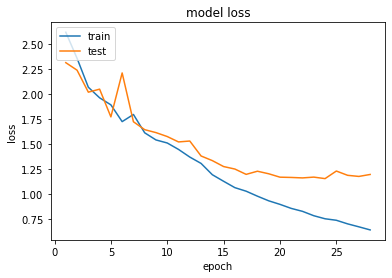

In [13]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()